# Feature Selection
Feature Selection is an important step in data pre-processing. It consists in selecting the best subset of input variable as the most pertinent. 



### Import Libraries

In [1]:
import scipy.stats as stats
import geopandas as gpd
from fs import methods as m
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, clear_output
from ipywidgets import AppLayout, Layout
from plotly.subplots import make_subplots
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_rows', 500)


**Periods** are collected in the _geopackages_ list ('0324_0331_2021' indicates the period between the 24th and 31st March 2021). 

For better highlighting the effect of intense agriculture with the usage of fertilizer and pesticides weeks preceding a rain period are selected.
The period choosen are the following:


| Grid value  | Period |
| ------------- | ------------- |
| '0324_0331_2021'  | 24th-31st March 2021   |
| '0418_0425_2021'  | 18th-25th April 2021  |
| '0717_0724_2021'  | 17th-24th July 2021   |
| '0903_0910_2021'  | 3rd-10th September 2021  |
| '1007_1014_2021'  | 7th-14th October 2021    |

**Configurations** are collected in the _params_ list by indicating the resolution and whether zone with Alpes and Prealpes are included or not.
In this way the test run can take in consideration
or not only urban and land areas, which are more affected by air pollution phenomena.

| Paramater value  | Period |
| ------------- | ------------- |
| '0_1_mountains'    | 10km resolution (0.1°) with all clim_zone (zone pedoclimatiche)   |
| '0_1_nomountains'  | 10km resolution (0.1°) without Alpes and Prealpes (clim_zone > 3) |
| '0_01_mountains'   | 1km resolution (0.01°) with all clim_zone (zone pedoclimatiche)   |
| '0_01_nomountains' | 1km resolution (0.01°) without Alpes and Prealpes (clim_zone > 3) |




In [2]:
#Periods
geopackages = ['0324_0331_2021','0418_0425_2021', '0717_0724_2021','0903_0910_2021','1007_1014_2021']

#Configuration
params = ['0_1_mountains', '0_1_nomountains', '0_01_mountains', '0_01_nomountains']

#List of labels from which are selected the '_st' variable
labels = list(gpd.read_file('assets/grids_0_1/grid_0_1_'+ geopackages[0]+'.gpkg').dropna(axis=0).dropna(axis=1).columns)

## Results Feature Selection
In this section fs results are evaluated for each geopackages contained in [this](https://github.com/opengeolab/D-DUST/tree/thesis_MB/notebooks/assets) folder.

<div>This notebook give you the possibility to compute the feature selection score for each parameterization. </br>
In particular you can interact by choosing the input and, after the computation, the output: </div>

<img align="right" width="230" height="400" src = assets/images/notebook.png>

### Input
- **Target variable**. It's possible to choose only variables from ARPA sensors (which end with '\_st'). The observations of the target variable selected are incremented using a buffer of values: the N empty cell closed to each sensor are set with an interpolated value (sensor observations are limited).<div></br></div>
[This](https://github.com/opengeolab/D-DUST/blob/thesis_MB/notebooks/buffer_knn.ipynb) is demonstration of how this works: the notebook shows how sensor values are interpolated with KNN notebook;
- **Variance threshold** : it's possible to select a minimum variance value for discarding variables with low variance;


### Output
- 4 **Configurations** (represented by _params_) are choosen:

- **Method**: For each period the barplot of the method selected is shown (with the possibility to normalize or not the results). <div> </br> </div>
    Scores are averaged through Borda Count. The methods used are:
    * Pearson correlation;
    * Spearmanr correlation;
    * Kendall tau; 
    * F-Test;
    * Random Forest importance; 
    * Recursive Feature Elimination;


- **Order** of variables by labels or by score;
- Barplot **scale**: Decimal or Logaritmic;


<div class="alert alert-warning" role="alert">
  This notebook is made especially for the feature selection for the grid data inside this repo. In order to use it generally for every different dataset it's needed to make some adjustment:

<ul>
<li><b>target variables</b> choosen are fixed and imported in a dropdown box. It's necessary to change values in this dropdown;</li>
<li> <b>data acquisition</b> the notebook processed grid data for each period and configuration (with 2 nested loop). So it's necessary to fix it in function of the structure of the data that have to be processed;</li>
<li> <b>configuration dropbox</b> since the resolutions and configuarations are fixed for this case of study, this must be fixed or, if not usefull, be removed;</li>

</ul>
</div>

<div class="alert alert-danger" role="alert">
 After you click on the compute button, the program needs more or less 5 minutes to compute each FS result for each configuration. 
</div>


<!---
The results are stored in dictionary a dictionaries of dataframe and are displayed in a bar plot.
-->


In [3]:
method_list = ['Pearson', 'Spearmanr', 'Kendall', 'Fisher', 'RF Importance', 'RFS']
var_t = 'empty'
target_labels = []
dictionary_results = {}
dataframes_results = {}

resolutions = []

#Variables of ARPA sensor are added to the dropdown widget
for l in labels:
    if(l.endswith('_st')):
        target_labels.append(l)

#Checkbox for normalize or not the results
results_norm = widgets.Checkbox(
    value=True,
    description='Results normalized',
    disabled=False,
    indent=True
)

#Radiobutton used to display data in regular or logaritmic scale
scale = widgets.RadioButtons(
    options=['Regular', 'Logaritmic'],
    description='Scale:',
    disabled=False
)

#compute_button_f is executed if clicked
compute_button = widgets.Button(
    description='Compute',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='Compute',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width='60%', margin='10px 150px 10px 80px')


)

#Radiobutton used to display data ordered by score or by labels
order = widgets.RadioButtons(
    options=['Labels', 'Scores'],
    description='Order by:',
    disabled=False
)
#Dropdown widget with the different configuration of the grid data
params_choosen = widgets.Dropdown(
    options= ['10km', '10km without mountains', '1km', '1km without mountains'],
    value = '10km',
    description='Parameter:',
    disabled=False,
    layout = Layout(width='95%')
)

#Dropdown widgets used to choose the scores of the method selected
method_choosen = widgets.Dropdown(
    options=['---']+ method_list + ['Borda Count Voting'],
    value='---',
    description='Method:',
    disabled=False,
    layout = Layout(width='90%')
)

#Dropdown widgets used to choose the target variable for FS
target_variable = widgets.Dropdown(
    options=target_labels,
    value=target_labels[0],
    description='Target:',
    layout = Layout(width='90%')
)
#Checkbox to include or not the VarianceThreshold filter
variance_TH= widgets.Checkbox(
    value=True,
    description='Apply filter low variance',
    disabled=False,
    indent=False,
    layout = Layout(margin='10px 10px 10px 50px')
)



labels_list = []

def compute_button_f(b):
    clear_output()
    global features_deleted
    global th
    global var_t
    global labels
    global dataframes_results
    global target_var
    labels_list.clear()


    var_t = target_variable.value
    
    for par in params:
        dataframes_results.clear()
        for index, grid in enumerate(geopackages):
            #Data acquisition depending of the resolution
            if(par[0:3] == '0_1'):
                data = gpd.read_file('assets/grids_0_1/grid_0_1_'+ grid+'.gpkg')
                #Data are 
                data = m.process_data(data, 10, target_variable.value)
            else:
                data = gpd.read_file('assets/grids_0_01/grid_0_01_'+ grid+'.gpkg')
                data = m.process_data(data, 30, target_variable.value)
            #PreAlpes and Alpes are filtered depending on the configuration
            if(par[-11:]=='nomountains'):
                data = data[data['clim_zone'] > 3]
            data.pop('clim_zone')
            #Data are cleaned by NaN values
            data = data[~data[target_variable.value].isnull()]
            data = data.dropna(axis=1).dropna(axis=0)
            data.pop('geometry')
            labels = list(data.columns)

            #read variables which are not null

            #Store dataset in x and y variables
            X = pd.DataFrame(data=data, columns=labels )
            Y = X[target_variable.value]
            Y = Y.values.ravel()
            X.pop(target_variable.value)
            X.pop('lat_cen')
            X.pop('lng_cen')
            
            #Data filtering with VarianceThreshold
            if variance_TH.value == True:
                scores_th = m.quasi_zero_variance(X, 20, 0.2)

                for i, label in enumerate(scores_th['Features']):
                    if scores_th['Scores'].tolist()[i] != 1:
                        X = X.drop(label, 1)

            #Data trasformation
            X = X.apply(stats.zscore)
            X = X.dropna(axis=1)
            Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

            labels = X.columns.tolist()
            labels_list.append(labels)
            score_results = pd.DataFrame()
            score_results['Features'] = labels

            score_results = m.fs_results_computation(X, Y)
            
            #Before borda count execution filter methods results are replaced by its absolute value since we are interested in both positive and negative correlation
            s = score_results.copy()
            s['Pearson'] = s['Pearson'].abs()
            s['Kendall'] = s['Kendall'].abs()
            s['Spearmanr'] = s['Spearmanr'].abs()


            var_t = target_variable.value
            score_results['Borda Count Voting'] = m.borda_voting(s)
            #this commented code is used to export results fro each different period
            #score_results.to_excel('assets/fs_results/'+par+grid+'out.xls')
            #score_results.to_csv('assets/fs_results/'+par+grid+'out.csv')

            #Each period are saved in dataframes_results
            dataframes_results[grid] = score_results.copy()
            
        method_choosen.value = '---'
        #Results of each different configuration is saved in dictionary_results
        dictionary_results[par] = dataframes_results.copy()


        target_var= target_variable.value


#Method used to visualize the results. When change_scale, method ecc change, this method is executed changing the results which are shown in that moment
def fs_manager(change_scale, method, normalized_results, target, order, filter_variance, param):

    if method == '---':
        return

    df = []

    if(param == '10km'):
        df = dictionary_results['0_1_mountains']
    if(param == '10km without mountains'):
        df = dictionary_results['0_1_nomountains']
    if(param == '1km'):
        df = dictionary_results['0_01_mountains']
    if(param == '1km without mountains'):
        df = dictionary_results['0_01_nomountains']
    res = []
    labels_list = []

    if(normalized_results):
        for grid in geopackages:
            temp = (df[grid])[method]
            temp = m.NormalizeData1D(temp)
            res.append(temp)
            labels_list.append(df[grid]['Features'].tolist())
    else:
        for grid in geopackages:
            temp = (df[grid])[method]
            labels_list.append(df[grid]['Features'].tolist())
            res.append(temp)


    if (change_scale == 'Logaritmic'):
        m.show_bars_log(labels_list, res, method, geopackages, order)
        return

    else:
        m.show_bars(labels_list, res, method, geopackages, order)

title= widgets.HTML('<h2 style="text-align:center;">Options</h2><hr><h3 style="padding: 10px;">Input</h3>')
features_deleted = widgets.HTML('')
title2 = widgets.HTML('<h2 style="text-align:center;">Feature Selection scores</h2><hr>')
plots = widgets.interactive_output(fs_manager, {'method':method_choosen, 'change_scale': scale, 'order':order, 'normalized_results': results_norm, 'target': target_variable, 'filter_variance':variance_TH,  'param':params_choosen})
plot = widgets.VBox([title2, plots], layout=Layout(border='solid'))
output = widgets.VBox([title, target_variable, variance_TH, compute_button,widgets.HTML('<br><h3 style="padding: 10px;">Output</h3'),params_choosen,
                           method_choosen, scale, order, results_norm], layout=Layout(border='solid'))

ui = AppLayout(header=None,
          left_sidebar=output,
          center=plot,
          right_sidebar=None,
          footer=None,
              layout=Layout(border='solid'))

compute_button.on_click(compute_button_f)

container = widgets.Box([ui], )
display(container)


Box(children=(AppLayout(children=(VBox(children=(HTML(value='<h2 style="text-align:center;">Options</h2><hr><h…

### Export feature selected
By running this section, dataframes containing the list of feature selected ordered by its Borda Count score value are shown with barplots and saved as .csv file.
A feature selection for each different configuration is provided.

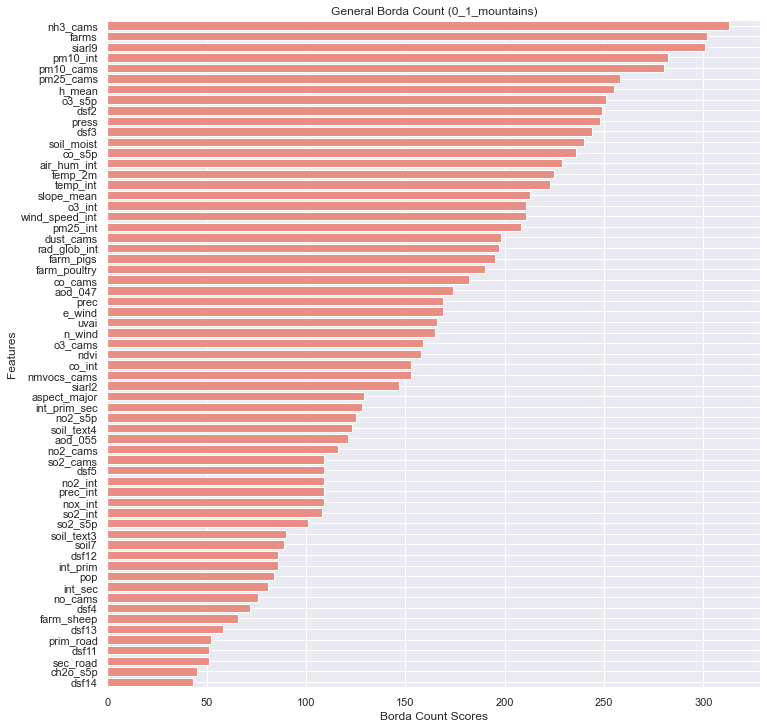

<Figure size 842.4x883.44 with 0 Axes>

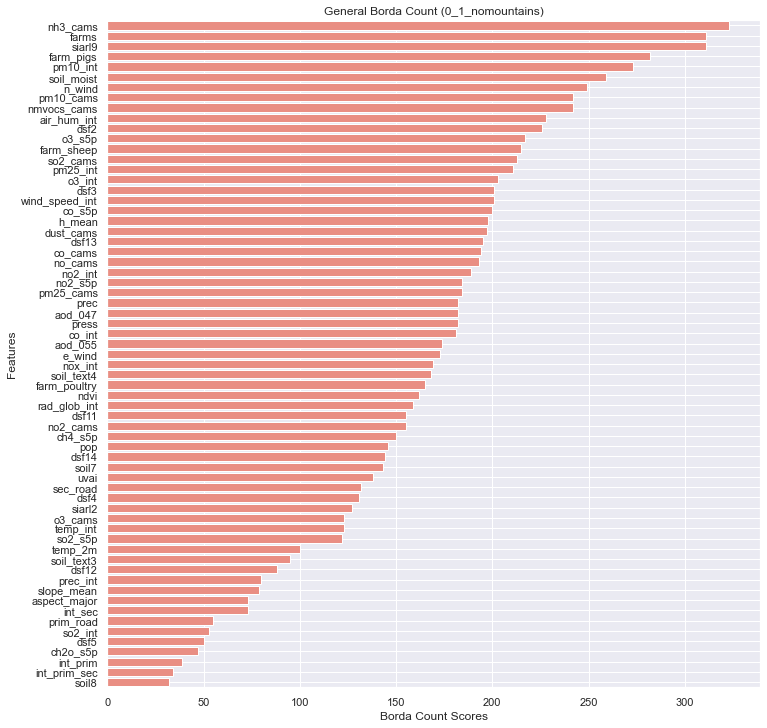

<Figure size 842.4x883.44 with 0 Axes>

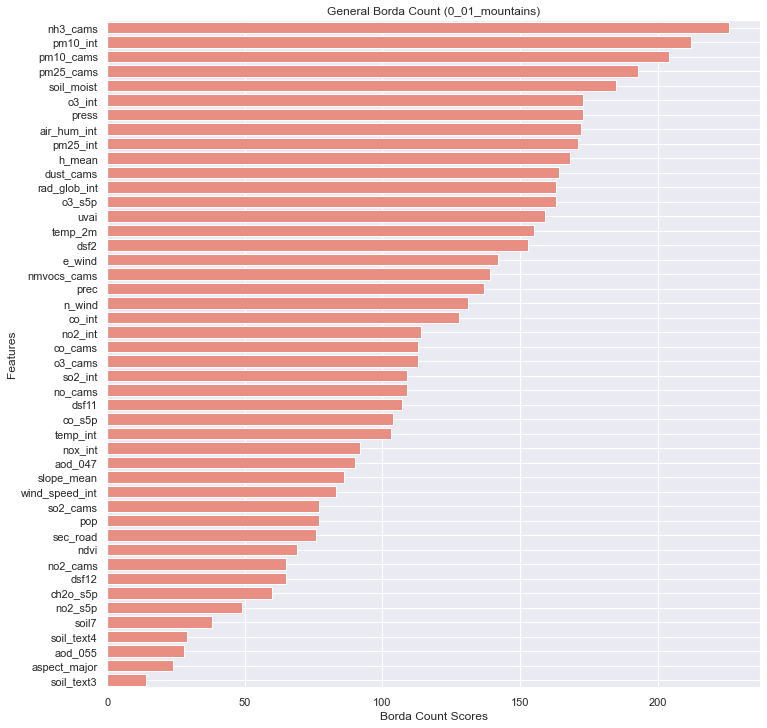

<Figure size 842.4x883.44 with 0 Axes>

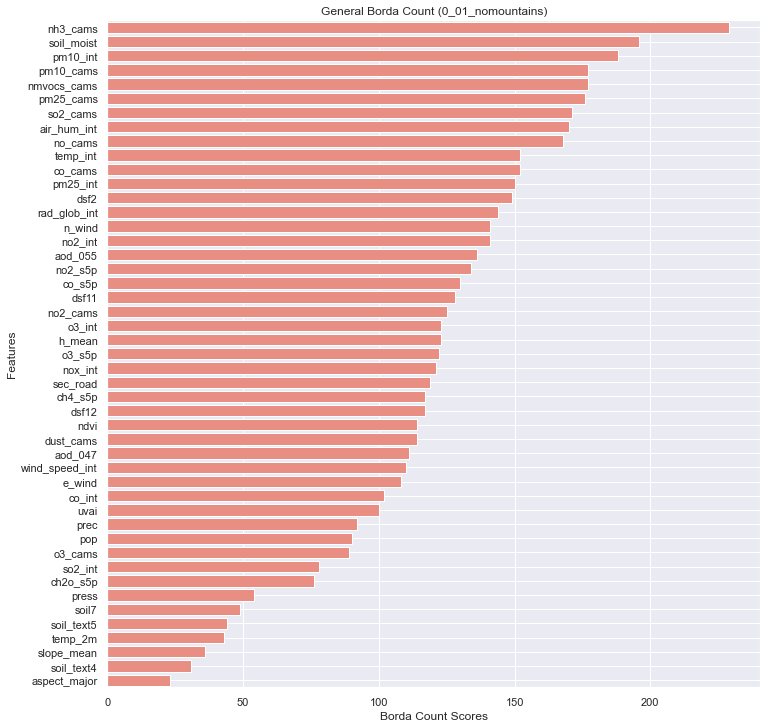

<Figure size 842.4x883.44 with 0 Axes>

In [4]:
for par in params:
    
    dataframes_results = dictionary_results[par]
    labels  = m.set_labels_df(dataframes_results, geopackages)
    borda_res = pd.DataFrame(columns = ['Features'] + geopackages )
    borda_res['Features'] = labels

    for index, grid in enumerate(geopackages):
        for l in borda_res['Features'].tolist():
            index = dataframes_results[grid].index[dataframes_results[grid]['Features'] == l].tolist()
            index2 = borda_res.loc[borda_res['Features'] == l].index[0]
            if index:
                index = index[0]
                borda_res.at[index2, grid] = dataframes_results[grid]._get_value(index, 'Borda Count Voting')
            else:
                borda_res.at[index2, grid] = 0
        
    #A Borda Count score is computed from the Borda Count of every period   
    borda_res['General Borda Count'] = m.borda_voting(borda_res)
    borda_res = borda_res.sort_values(by=['General Borda Count'], ascending = False)
    borda_res.to_csv('assets/fs_results/'+target_var+par+'_features_model.csv')

    #Bar plot visualisation
    sns.set()
    sns.set(rc={'figure.figsize':(11.7,12.27)})
    f = plt.figure()
    sns.barplot(
    y='Features', 
    x='General Borda Count',
    color='salmon', 
    data=borda_res
)

    
    plt.xticks(rotation=0)
    plt.ylabel("Features")
    plt.xlabel("Borda Count Scores")
    plt.title('General Borda Count ('+par+')')
    plt.gca().yaxis.grid(linestyle='-')
    fig = f.get_figure()
    fig.savefig('assets/fs_results/'+par+target_var+'.png', bbox_inches='tight')
    plt.show()
    plt.clf()
    


    


### Pearson results
In this section each barplot of pearson index is shown to better visualize the positive/negative correlation of each variable with respect to the target variable selected.

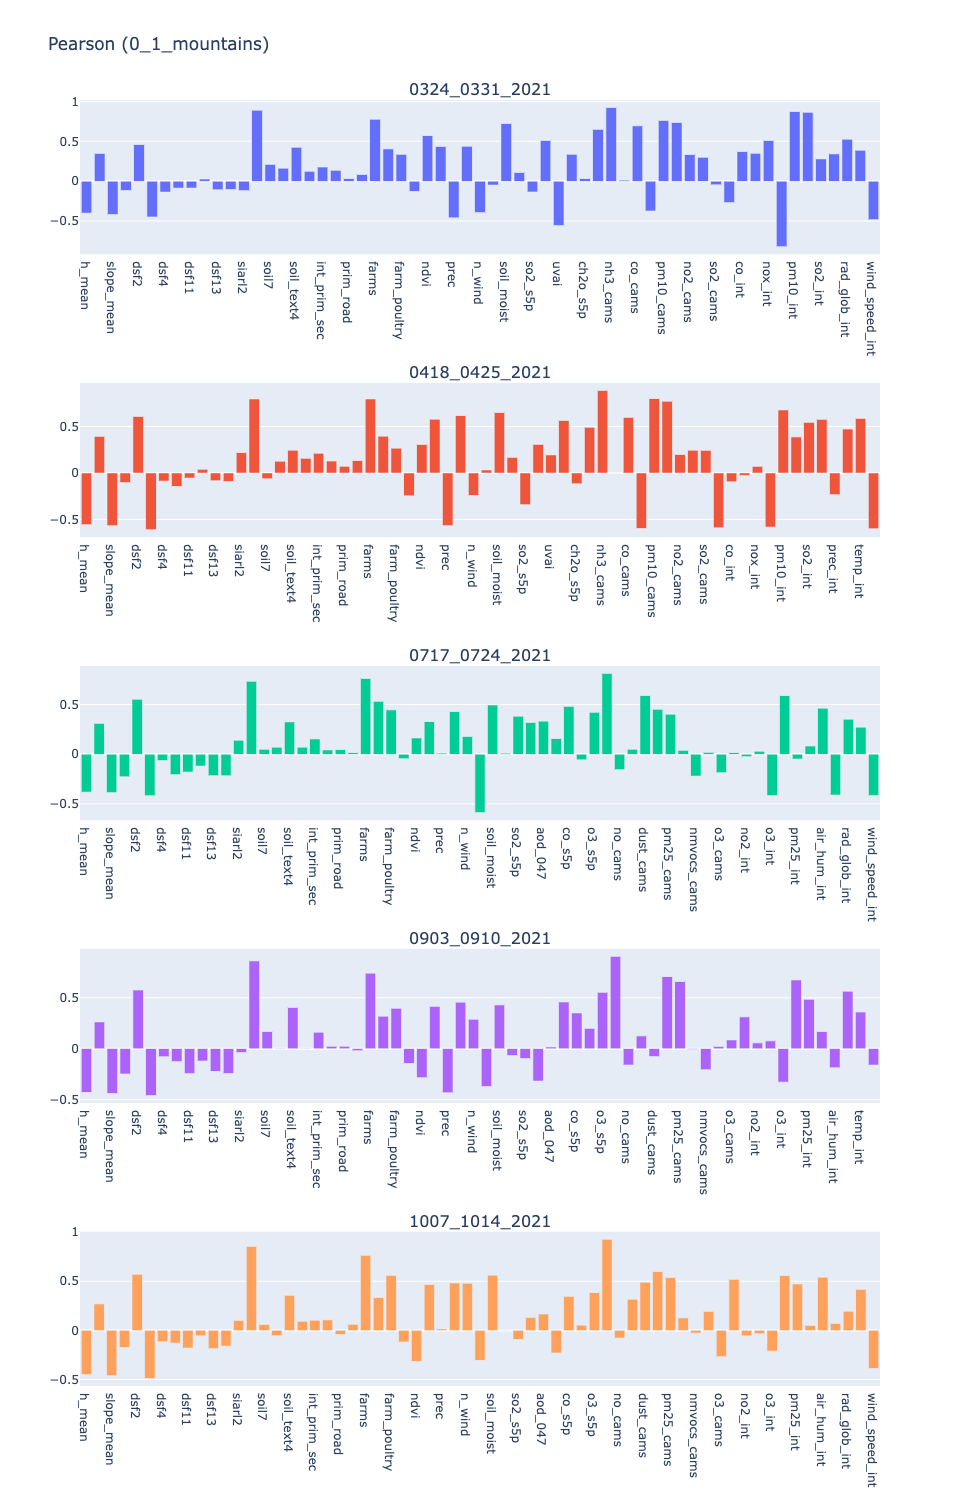

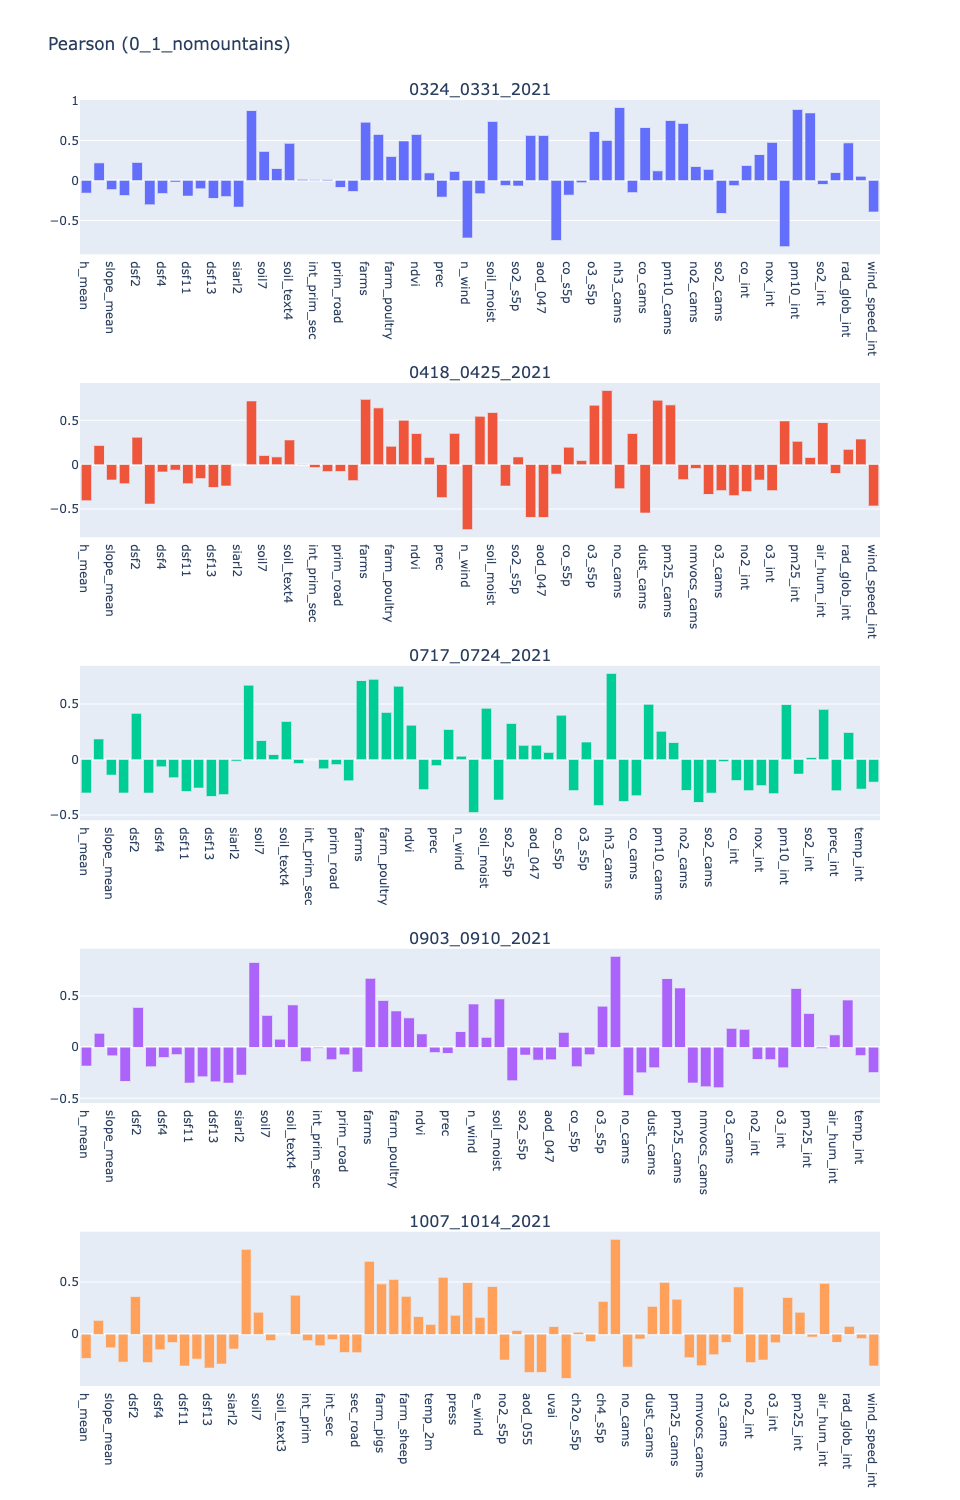

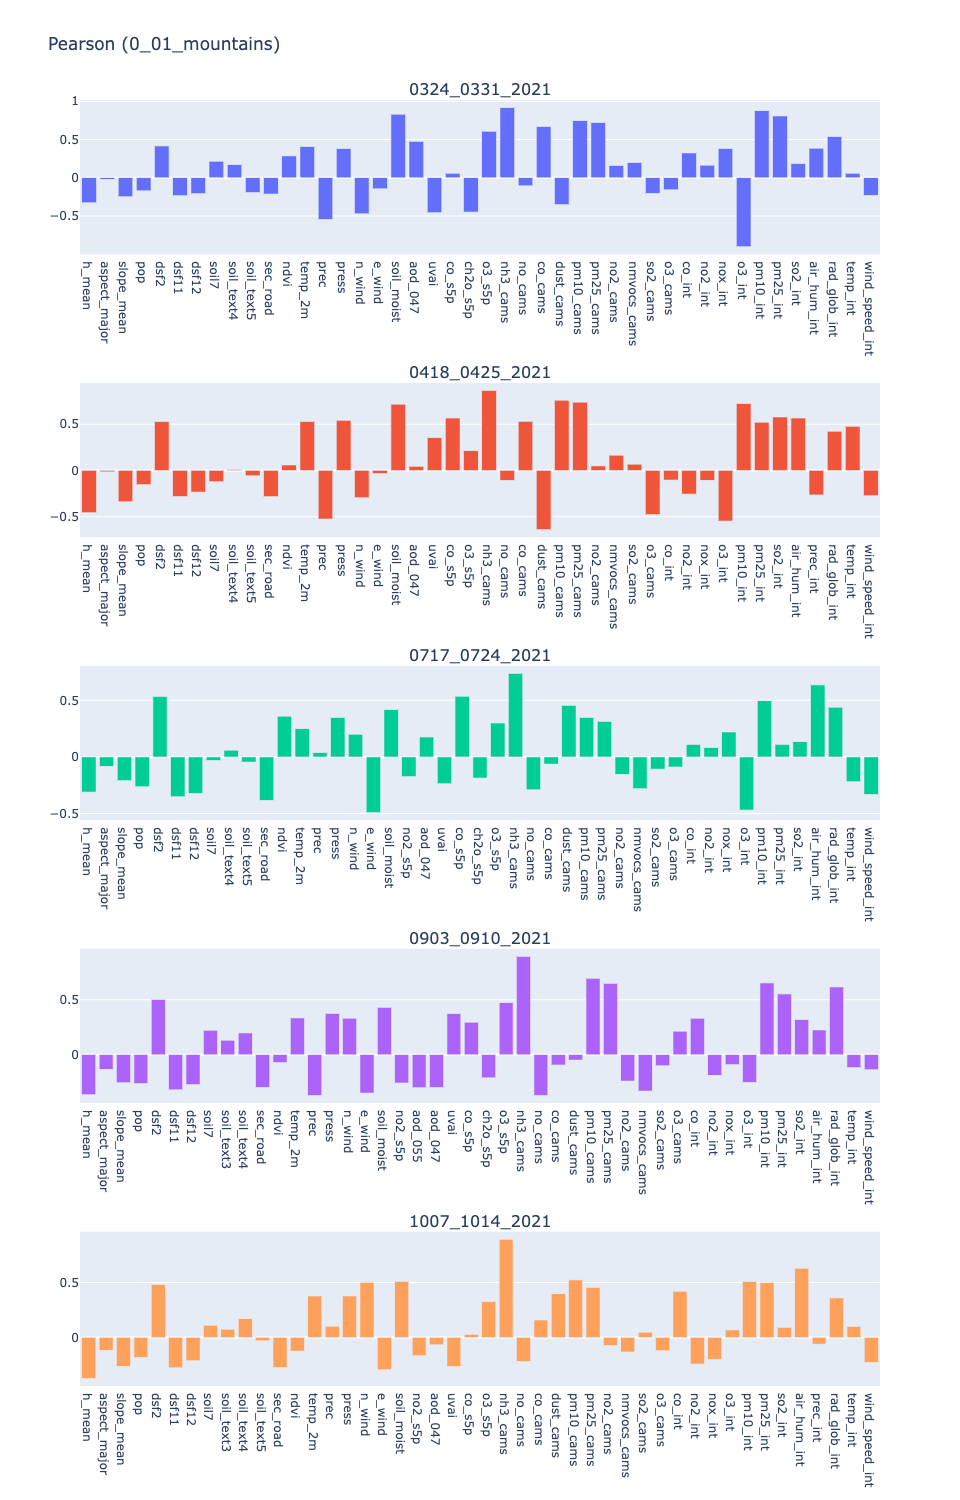

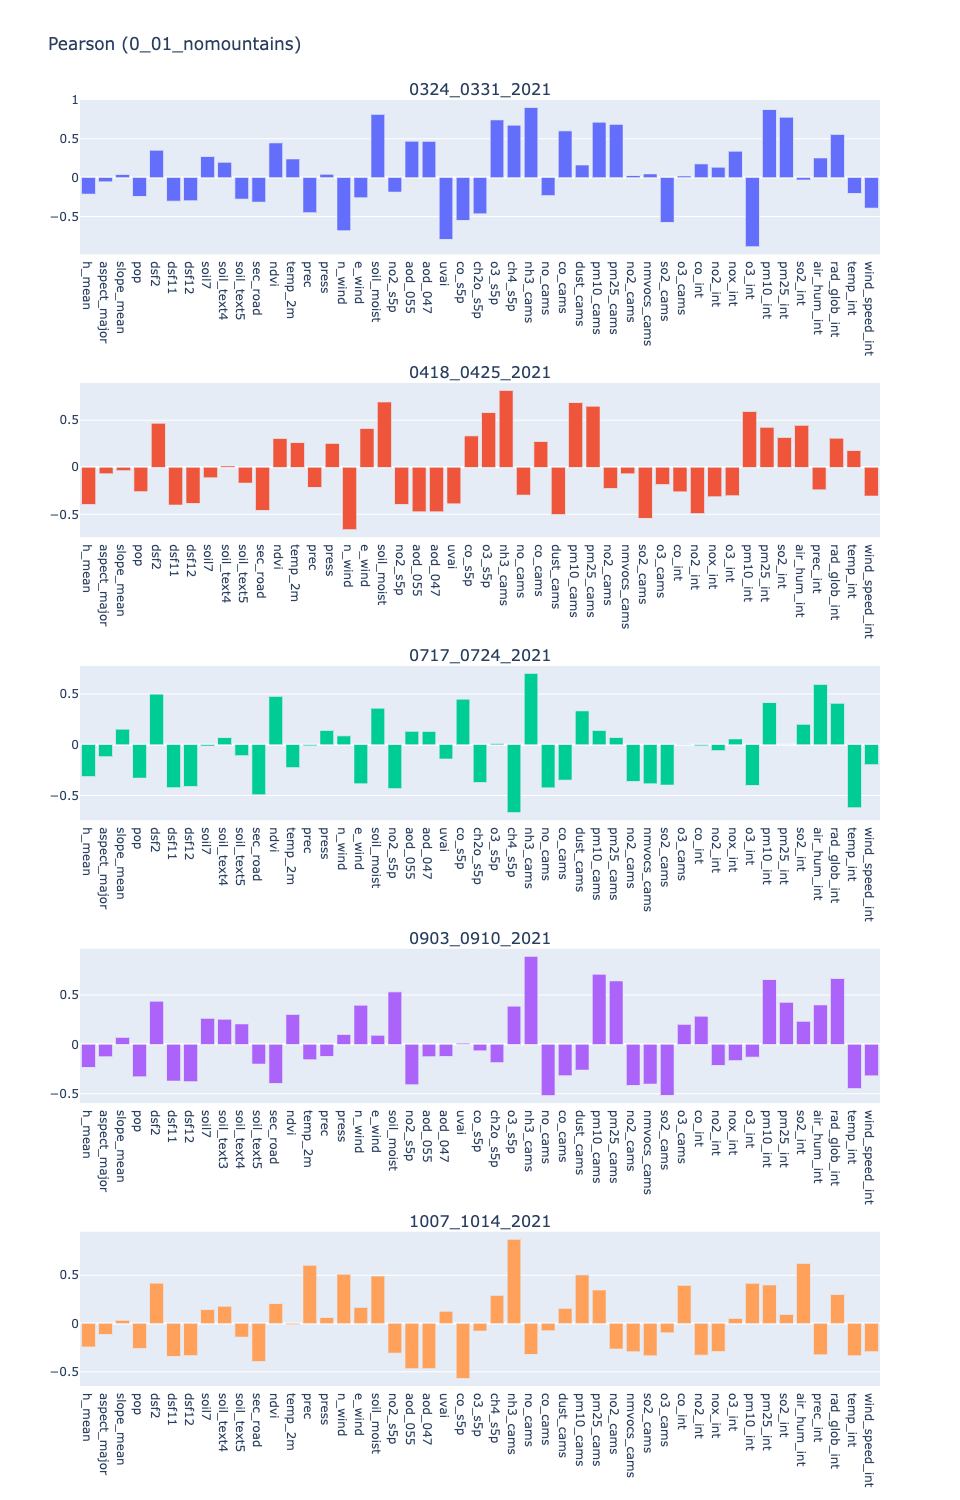

In [5]:
for par in params:
    dataframes_results = dictionary_results[par]
    fig = make_subplots(rows=5, cols=1, subplot_titles=geopackages)
    for index, grid in enumerate(geopackages):
        labels = dataframes_results[grid]['Features'].tolist()
        values = dataframes_results[grid]['Pearson'].tolist()
        fig.add_trace(go.Bar(x=labels, y=values), row=index+1, col=1)
        fig.update_yaxes(row=index+1, col=1)
        fig.update_xaxes(type="category", row=index+1, col=1)

    fig.update_layout(height=1500, width=1000 , title_text='Pearson (' +par+ ')')
    fig.update_layout(showlegend=False, autosize=True)
    fig.show()
    fig.write_image('assets/fs_results/'+par+target_var+'_pearson.png')

